In [1]:
# Classificação 

In [2]:
# imports
import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve

In [3]:
# baixar o dataset
mnist = fetch_openml('mnist_784', version = 1)
mnist.keys

C:\Users\hudso\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


<function Bunch.keys>

In [4]:
X , y = mnist['data'], mnist['target']

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

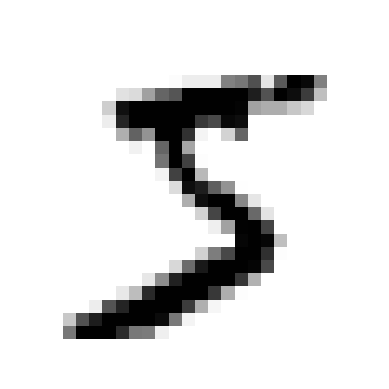

In [7]:
# mostra um numero 

some_digit = X.iloc[0]
some_digit_image = some_digit.values.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()


In [8]:
y[0]
y = y.astype(np.uint8)

In [9]:
# Dividir o conjunto, test e train
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [10]:
# Treinando o classificador binario 
y_train_5 = y_train == 5
y_test_5 = y_test == 5

In [11]:
# usar o SGDClassifier, vantagem é lidar bem com um volume grandes de dados
# pois ele lida com as instancias de forma independente, uma de cada vez.
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
# detecta imagens do numero 5
sgd_clf.predict([some_digit])


C:\Users\hudso\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

In [13]:
# Cáculo do desempenho
# usando validação cruzada
cross_val_score(sgd_clf, X_train, y_train_5, cv= 3, scoring = 'accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [14]:
# classificador ruim, que classifica somente os não 5
class NeverClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1),dtype = bool)

In [15]:
# estimar a acurácia
never_5_clf = NeverClassifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3,
               scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [16]:
# Acurácia não é bom para classificador, ainda mais com dados assimétricos, ou seja, 
# quando algumas classes estão mais presentes do que outras.

In [17]:
# Matriz de Confusão
# boa maneira de abaliar o desempenho de classificador 
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [18]:
# Usar a matriz de confusão com com a classe alvo e as classes previstas
confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [19]:
# A primeira linha considera as imagens não 5(classe negativa): 53,892 foram classificadas corretamente como não 5(True negativos)
# enquanto 0.687 foi classificadas de forma errada como 5s(falsos positivos)
# A segunda linha considera como imagens 5s(classe positiva):1.891 classificada errada como não-5s falsos negativos
# ao passo que 3.530 restante foi classificadas como perfeitamente como 5s(verdadeiros positivos)
# um classificador ideal só teria verdadeiros positivos e verdadeiros negativos, ou seja, só teria a diagonal principal.

In [20]:
y_train_perfect_predictions = y_train_5 # fingindo que alcançamos a perfeição
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [21]:
# A matriz fornece bastante informação mas talvez uma métrica mais concisa seja melhor.
# Vamos obsevar a acurácia das predições positivas, precisão do classificador
# Precisao = TP/ (TP + FP)
# TP são os verdadeiros positivos e FP são os falsos positivos 
# Outra métrica é usada, chamada de revocação(sensibilidade ou tava de verdadeiros positivos(TPR)). Proporção de instancias 
# positivas que são detectadas corretamente pelo classificador

# revocacao = TP(TP + FN), FN = falsos negativos

In [22]:
# Precision e Recall
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [23]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [24]:
# não parece tão bom 
# Vamos encaixar essas duas medidas em só uma, chamada de F1(score), nada mais é do que uma média harmonica
# de predição e revocação, media harmonica da mais importancia aos valores mais baixos, logo tera um score F1 alto
# se a revocação e a precisão forem altas
# basta usar a função abaixo
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [25]:
# trade-off precision/recall
# usando a sgd_classifier com exemplo
y_scores = sgd_clf.decision_function([some_digit])
y_scores

C:\Users\hudso\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [26]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [27]:
# Vamos aumentar o limiar
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [28]:
# O que usar ?
# Vamos primeiro usar a func cross_val_predict para obter os scores de tds as instancias no conjunto de treinamento
y_scores = cross_val_predict(sgd_clf, X_train,y_train_5,cv=3,
                            method='decision_function')

In [29]:
# com esses scores vamos usar outra função para calcular a precisão e a revocaçãode todos os limiares possíveis
precisions, recalls,thresholds = precision_recall_curve(y_train_5, y_scores)

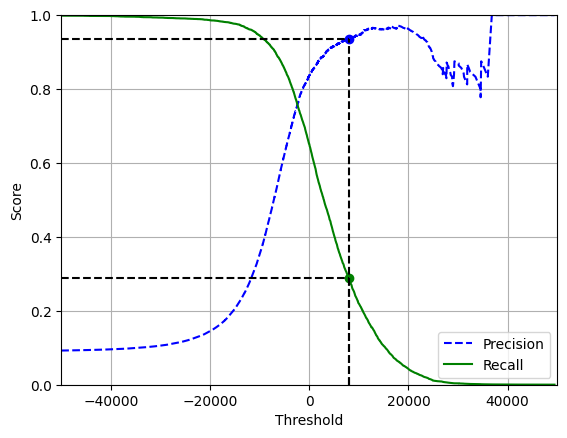

In [30]:
import matplotlib.pyplot as plt

# Função para plotar precisão e recall em relação ao limiar
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')

    # Adiciona ponto na curva de precisão no limiar 8000
    index_precision_8000 = (np.abs(thresholds - 8000)).argmin()
    plt.scatter(thresholds[index_precision_8000], precisions[index_precision_8000], color='blue')

    # Adiciona ponto na curva de recall no limiar 8000
    index_recall_8000 = (np.abs(thresholds - 8000)).argmin()
    plt.scatter(thresholds[index_recall_8000], recalls[index_recall_8000], color='green')

    # Adiciona linha tracejada até o eixo y a partir do ponto de precisão
    plt.plot([thresholds[index_precision_8000], thresholds[index_precision_8000]], [0, precisions[index_precision_8000]], 'k--')

    # Adiciona linha tracejada até o eixo y a partir do ponto de recall
    plt.plot([thresholds[index_recall_8000], thresholds[index_recall_8000]], [0, recalls[index_recall_8000]], 'k--')

    # Adiciona linha tracejada horizontal do ponto de precisão até o eixo y
    plt.plot([-50000, thresholds[index_precision_8000]], [precisions[index_precision_8000], precisions[index_precision_8000]], 'k--')

    # Adiciona linha tracejada horizontal do ponto de recall até o eixo y
    plt.plot([-50000, thresholds[index_recall_8000]], [recalls[index_recall_8000], recalls[index_recall_8000]], 'k--')

    # Adicionar legenda, rótulos de eixo e grade
    plt.legend()
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    
    # Definir limites personalizados para o eixo X
    plt.xlim(-50000, 50000)
    plt.ylim(0, 1)

    plt.grid(True)

# Chame a função com suas listas de precisões, recalls e thresholds
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

# Exiba o gráfico
plt.show()


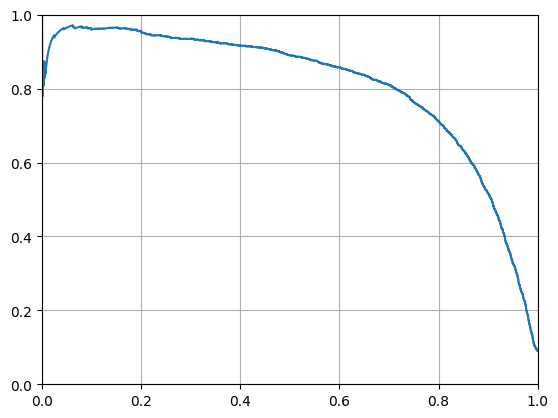

In [31]:
# grafico direto precision and recall
plt.plot(recalls,precisions)
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid(True)

In [32]:
# threshold com 90% de precisão
threshold_90_precision = thresholds[np.argmax(precisions >=0.9)]

In [33]:
y_train_pred_90 = y_scores > threshold_90_precision

In [34]:
precision_score(y_train_5, y_train_pred_90)

0.9

In [35]:
recall_score(y_train_5, y_train_pred_90)

0.47980077476480354

In [36]:
# A curva ROC(representa a taxa de verdadeiros positivos por taxa de de positivos falsos(FPR), onde o FPR é a proporção
# de instancias negativas classificadas incorretamente como positivas)
# É igual a taxa de verdadeiros negativos(TNR) que é a proporção de instancias negativas que são corretamente classificadas como
# negativas.Também chamado de especificidade(TNR)
fpr,tpr, threshold = roc_curve(y_train_5, y_scores)

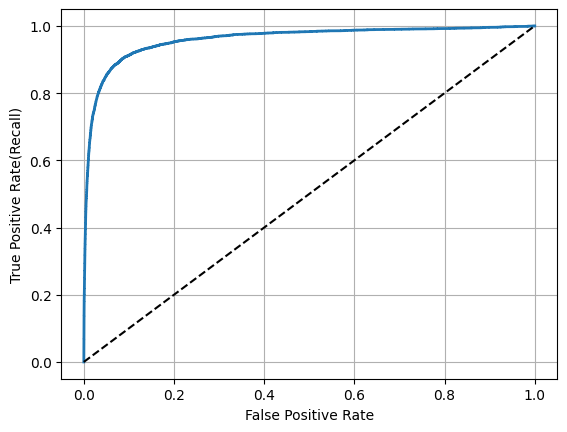

In [37]:
# Plotar o gráfico
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr,tpr, linewidth=2, label = label)
    plt.plot([0,1],[0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate(Recall)')
    plt.grid(True)
plot_roc_curve(fpr, tpr)
plt.show()

In [38]:
# forma de comparar os classificadores é a área sobre a curva(AUC)
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [39]:
# Usando a random e comparar a ROC e score ROC AUC.
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state =42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method='predict_proba')

In [40]:
y_scores_forest = y_probas_forest[:,1] # score = probabilidade de classe positiva
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)


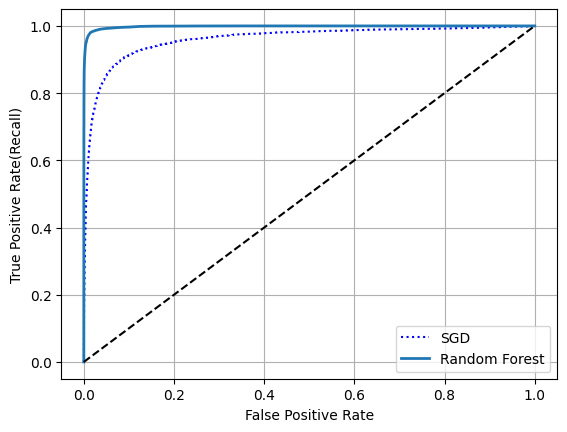

In [41]:
# Plotar a curva ROC, ajuda se representar a primeira curva ROC
plt.plot(fpr, tpr, "b:", label='SGD')
plot_roc_curve(fpr_forest,tpr_forest,'Random Forest')
plt.legend(loc ='lower right')
plt.show()

In [42]:
# verificar o score
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [43]:
# CLASSIFICAÇÃO MULTICLASSE 

# Estratégia One-versus-the-rest (OvR):no caso dos numeros de 0 a 9, seria treinar 10 classificadores, um pra cada alg
# Quando quiser classificar a imagem, basta obter o score de decisão pra cada imagem e seleciona a classe que tem a saída
# de maior score

#Estratégia one-versus-one (OvO): treinar o classificador binário pra cada par de algs. 
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train e não o y_train_5( para as multiclasses)
svm_clf.predict([some_digit])


C:\Users\hudso\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [44]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

C:\Users\hudso\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [45]:
np.argmax(some_digit_scores)

5

In [46]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [47]:
svm_clf.classes_[5]

5

In [48]:
# treinar um SGD
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

C:\Users\hudso\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([3], dtype=uint8)

In [49]:
sgd_clf.decision_function([some_digit])

C:\Users\hudso\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [50]:
# Não precisou rodar o OvR ou Ovo, pq o classificador SGD pode classificar direto as instancias em varias classes.
# Os scores estão bastante confiante, o menor valor em módulo é do alg 5, há uma dúvida no alg 3 que possui um valor positivo
# Usar a validação cruzada

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [51]:
# Para melhorar essa acurácia vamos aplicar o escalonamento das entradas
from sklearn.preprocessing import StandardScaler
scaler =  StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [52]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3,scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

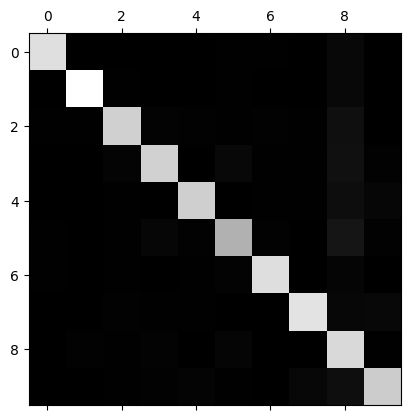

In [53]:
# Análise de Erro
# Encontrei o modelo ideal e quero melhora-lo -> Tipos de erros que o modelo comete
# ANALISE DA MATRIZ DE CONFUSÃO 
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx # Análise ruim, usa o matplotlib
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

In [54]:
# Esta matriz de confusao é boa, pq parte as imagens estão na diagonal principal
# significa que foram classificadas corretamente
# 5s são um pouco mais escuro, pode indicar que possui menos imagens 5s no conjunto de dados ou que n funciona tão bem com os 5s

In [55]:
# Dito isso, agr precisamos "normalizar" esse dados da matriz de confusão
# vamos dividir pelo numero de imagens da classe correspondente de modo a ter uma taxa e não um valor absoluto(pois faria com 
# que classes numerosas parecessem ruins)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx /row_sums

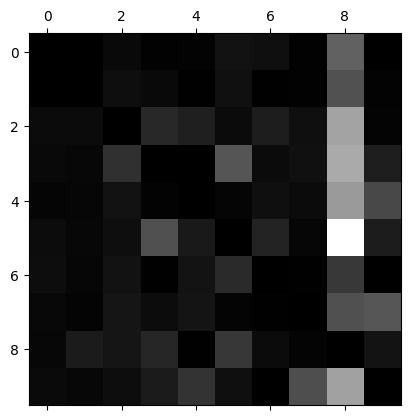

In [56]:
# preencher a diagonal com zeros para manter somente os erros e plotar o resultado
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap= plt.cm.gray)
plt.show()

In [57]:
# As linhas representam classes reais, colunas representam classes previstas
# Mais clareza indica que tem uma classificação errada.

In [58]:
# melhorando o modelo

cl_a, cl_b = 3,5
X_aa = X_train[(y_train == cl_a) & (y_train_pred ==cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred ==cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred ==cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred ==cl_b)]

In [59]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [np.array(instances.iloc[i]).reshape(size, size) for i in range(instances.shape[0])] #change done here
    
    if images_per_row == 0:
       images_per_row = 0.1
    
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")


In [96]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

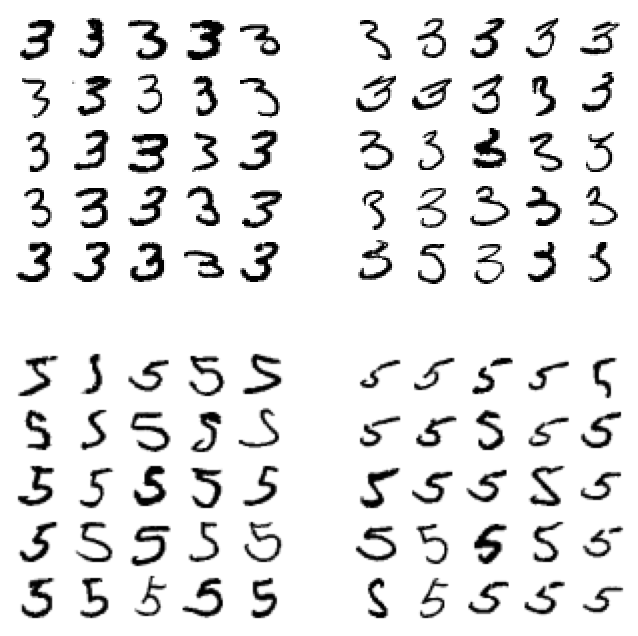

In [60]:
plt.figure(figsize=(8,8))
plt.subplot(221);plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222);plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223);plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224);plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [61]:
# Multirótulo
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train>=7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [62]:
knn_clf.predict([some_digit])

C:\Users\hudso\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\hudso\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\hudso\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


array([[False,  True]])

In [63]:
# Uma abordagem para o classificador multirótulo, calculo do F1 score para rotulo individual 
# Depois calcular a média 
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

AttributeError: 'Flags' object has no attribute 'c_contiguous'

In [67]:
np.zeros(0)

array([], dtype=float64)

In [97]:
noise = np.random.randint(0,100,(len(X_train),784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100,(len(X_test),784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

KeyError: 0

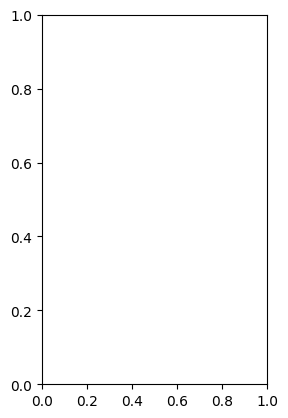

In [99]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

In [94]:
# treinar o classificador que limpa a imagem
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")

NameError: name 'some_index' is not defined

In [2]:
import sklearn
print(sklearn.__version__)



1.3.0
